In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

data_dir = '../input/leafdataset/training'

train_val_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        validation_split=0.2,
                                        preprocessing_function=preprocess_input)

train_gen = train_val_data_gen.flow_from_directory(directory=data_dir,
                                                   target_size=(256,256),
                                                   color_mode='rgb',
                                                   classes=None, # can be set to labels
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True,
                                                   seed=seed,
                                                   subset='training')
val_gen = train_val_data_gen.flow_from_directory(directory=data_dir,
                                                 target_size=(256,256),
                                                 color_mode='rgb',
                                                 classes=None, # can be set to labels
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=seed,
                                                 subset='validation')

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


In [ ]:
input_shape = (256, 256, 3)
initial_epochs = 10 #epochs in which vgg layers are kept frozen
epochs = 90

In [ ]:
conv_vgg16 = tfk.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
conv_vgg16.summary()

2021-11-27 17:56:34.941951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 17:56:35.049551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 17:56:35.050271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 17:56:35.051464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
input_layer = tfk.Input(shape=input_shape, name='Input')
conv = conv_vgg16(input_layer)
global_pooling = tfkl.GlobalAveragePooling2D()(conv)
classifier_layer1 = tfkl.Dense(units=512, name='Classifier1', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(1e-5), activation='relu')(global_pooling)
classifier_layer1 = tfkl.Dropout(0.3, seed=seed)(classifier_layer1)
classifier_layer2 = tfkl.Dense(units=256, name='Classifier2', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(1e-5), activation='relu')(classifier_layer1)
classifier_layer2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer2)
classifier_layer3 = tfkl.Dense(units=128, name='Classifier3', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer=tfk.regularizers.l2(1e-5), activation='relu')(classifier_layer2)
classifier_layer3 = tfkl.Dropout(0.3, seed=seed)(classifier_layer3)
output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer3)

complete_model = tfk.Model(inputs=input_layer, outputs=output_layer, name='VGG16-3HL-GlobAvPool-Unfreeze')

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
Model: "VGG16-3HL-GlobAvPool-Unfreeze"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
Classifier1 (Dense)          (None,

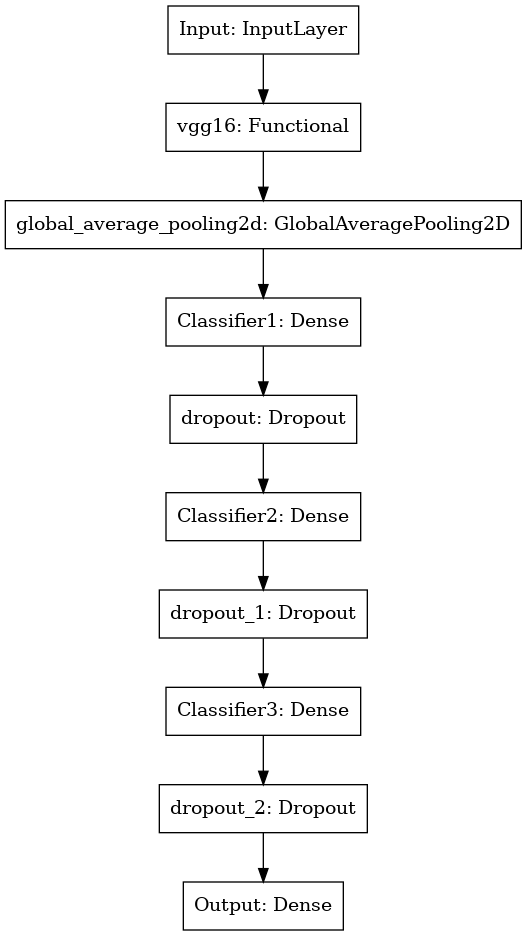

In [ ]:
# Froze the layers
for i, layer in enumerate(complete_model.get_layer('vgg16').layers[:]):
    layer.trainable=False
for i, layer in enumerate(complete_model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

# Compile the model
complete_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics='accuracy')
complete_model.summary()
tfk.utils.plot_model(complete_model)

In [ ]:
patience = 15
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)

In [ ]:
checkpoint_path = 'training_vgg16/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=False,
                                                verbose=1)

In [ ]:
complete_history = complete_model.fit(
    x = train_gen,
    epochs = initial_epochs,
    validation_data = val_gen,
    callbacks = [early_stopping, cp_callback]
).history

2021-11-27 17:56:39.968932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-27 17:56:42.486575: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


444/444 [==============================] - 377s 827ms/step - loss: 3.8984 - accuracy: 0.1737 - val_loss: 1.9642 - val_accuracy: 0.4145

Epoch 00001: saving model to training_vgg16/cp.ckpt
Epoch 2/10
444/444 [==============================] - 267s 600ms/step - loss: 2.5990 - accuracy: 0.2991 - val_loss: 1.7058 - val_accuracy: 0.5264

Epoch 00002: saving model to training_vgg16/cp.ckpt
Epoch 3/10
444/444 [==============================] - 278s 626ms/step - loss: 2.1509 - accuracy: 0.3884 - val_loss: 1.5303 - val_accuracy: 0.5767

Epoch 00003: saving model to training_vgg16/cp.ckpt
Epoch 4/10
444/444 [==============================] - 278s 625ms/step - loss: 1.8863 - accuracy: 0.4582 - val_loss: 1.3828 - val_accuracy: 0.6086

Epoch 00004: saving model to training_vgg16/cp.ckpt
Epoch 5/10
444/444 [==============================] - 285s 641ms/step - loss: 1.6741 - accuracy: 0.5186 - val_loss: 1.2888 - val_accuracy: 0.6304

Epoch 00005: saving model to training_vgg16/cp.ckpt
Epoch 6/10
444/4

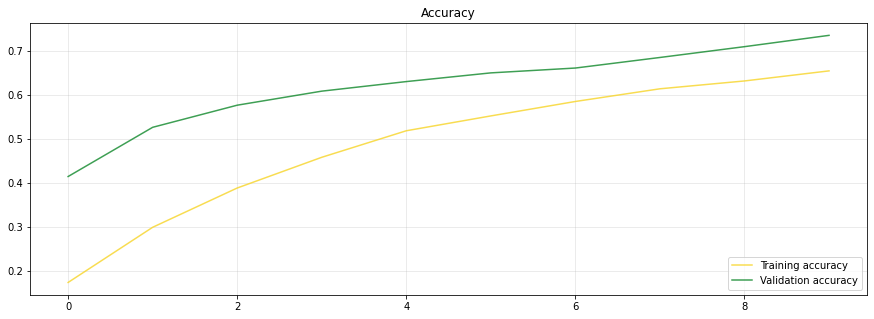

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(complete_history['accuracy'], label='Training accuracy', alpha=.8, color='#F7D426')
plt.plot(complete_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#0E8729')
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.savefig('vgg_unfreeze1.png')
plt.show()

In [ ]:
# Last 4 Conv2D are set to trainable
for i, layer in enumerate(complete_model.get_layer('vgg16').layers[14:]):
    layer.trainable=True
for i, layer in enumerate(complete_model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

# Recompile the model
complete_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics='accuracy')
complete_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "VGG16-3HL-GlobAvPool-Unfreeze"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
Classifier1 (Dense)          (None, 512)

In [ ]:
complete_history = complete_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = [early_stopping, cp_callback]
).history

Epoch 1/90
444/444 [==============================] - 287s 644ms/step - loss: 0.8118 - accuracy: 0.7492 - val_loss: 0.5283 - val_accuracy: 0.8389

Epoch 00001: saving model to training_vgg16/cp.ckpt
Epoch 2/90
444/444 [==============================] - 289s 650ms/step - loss: 0.5241 - accuracy: 0.8352 - val_loss: 0.4221 - val_accuracy: 0.8675

Epoch 00002: saving model to training_vgg16/cp.ckpt
Epoch 3/90
444/444 [==============================] - 286s 644ms/step - loss: 0.3779 - accuracy: 0.8826 - val_loss: 0.4094 - val_accuracy: 0.8697

Epoch 00003: saving model to training_vgg16/cp.ckpt
Epoch 4/90
444/444 [==============================] - 287s 647ms/step - loss: 0.3070 - accuracy: 0.9058 - val_loss: 0.3396 - val_accuracy: 0.8997

Epoch 00004: saving model to training_vgg16/cp.ckpt
Epoch 5/90
444/444 [==============================] - 283s 638ms/step - loss: 0.2266 - accuracy: 0.9318 - val_loss: 0.2815 - val_accuracy: 0.9231

Epoch 00005: saving model to training_vgg16/cp.ckpt
Epoch

In [ ]:
complete_model.save('VGG16-3HL-GlobAvPool-Unfreeze')

2021-11-27 22:55:04.314671: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


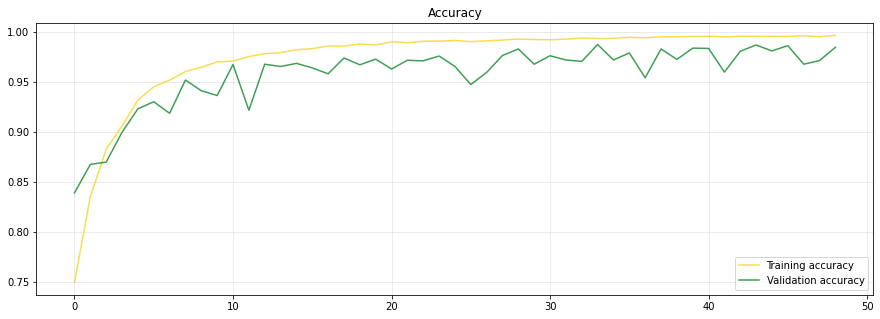

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(complete_history['accuracy'], label='Training accuracy', alpha=.8, color='#F7D426')
plt.plot(complete_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#0E8729')
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.savefig('vgg_unfreeze2.png')
plt.show()